# Visualizing phylogenetic trees

First we import libraries and assign each country a color for plotting.

In [1]:
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import baltic as bt
import numpy as np
from scipy.stats import gaussian_kde

# matplotlib theme
prop = mpl.font_manager.FontProperties( 'Roboto' )
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 16

mpl.rcParams['figure.dpi'] = 200

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

color_map = {
    "Zambia" : "#009E73", # green
    "Mozambique" : "#56B4E9", # blue
    "Nigeria" : "#0072B2",  # reddish-purple
    "Cameroon" : "#D55E00", # brown 
    "Democratic Republic of the Congo" : COLOR, #Black
    "Uganda" : "#F0E442",
    "Malawi" : "#E69F00", # orange 
    "Other" : "#C8C8C8" # grey
}

Next we write some functions to make plotting phylogenetic trees horizontally.

In [2]:
def hpd( data, level ):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list( data )
    d.sort()

    nData = len( data )
    nIn = int( round( level * nData ) )
    if nIn < 2:
        return None
    # raise RuntimeError("Not enough data. N data: %s"%(len(data)))

    i = 0
    try:
        r = d[i + nIn - 1] - d[i]
    except IndexError:
        print( i )
        print( nIn )
        print( d )
        raise

    for k in range( len( d ) - (nIn - 1) ):
        rk = d[k + nIn - 1] - d[k]
        if rk < r:
            r = rk
            i = k

    assert 0 <= i <= i + nIn - 1 < len( d )

    return (d[i], d[i + nIn - 1])


# This is a rip of @evogytis baltic plotting function, but with the ability to plot horizontally.
def plotTree( self, ax, connection_type=None, target=None,
              x_attr=None, y_attr=None, width=None,
              colour=None, horizontal=False, **kwargs ):
    if target is None: target = lambda k: True
    if x_attr is None: x_attr = lambda k: k.x
    if y_attr is None: y_attr = lambda k: k.y
    if width is None: width = 2
    if colour is None: colour = 'k'
    if connection_type is None: connection_type = 'baltic'
    assert connection_type in ['baltic', 'direct', 'elbow'], 'Unrecognised drawing type "%s"' % (tree_type)

    branches = []
    colours = []
    linewidths = []
    for k in filter( target, self.Objects ):  ## iterate over branches
        x = x_attr( k )  ## get branch x position
        xp = x_attr( k.parent ) if k.parent else x  ## get parent x position
        y = y_attr( k )  ## get y position

        try:
            colours.append( colour( k ) ) if callable( colour ) else colours.append( colour )
        except KeyError:
            colours.append( (0.7, 0.7, 0.7) )
        linewidths.append( width( k ) ) if callable( width ) else linewidths.append( width )

        if connection_type == 'baltic':
            if horizontal:
                branches.append( ((y, xp), (y, x)) )
            else:
                branches.append( ((xp, y), (x, y)) )

            if k.is_node():
                yl, yr = y_attr( k.children[0] ), y_attr( k.children[-1] )
                if horizontal:
                    branches.append( ((yl, x), (yr, x)) )
                else:
                    branches.append( ((x, yl), (x, yr)) )
                linewidths.append( linewidths[-1] )
                colours.append( colours[-1] )
        elif connection_type == 'elbow':
            yp = y_attr( k.parent ) if k.parent else y  ## get parent x position
            branches.append( ((xp, yp), (xp, y), (x, y)) )
        elif connection_type == 'direct':
            yp = y_attr( k.parent )  ## get y position
            branches.append( ((xp, yp), (x, y)) )
        else:
            pass  ## for now

    if 'capstyle' not in kwargs: kwargs['capstyle'] = 'projecting'
    line_segments = LineCollection( branches, lw=linewidths, color=colours, **kwargs )
    ax.add_collection( line_segments )
    return ax


# This is a rip of @evogytis baltic plotting function, but with the ability to plot horizontally.
def plotPoints( tree, ax, x_attr=None, y_attr=None, target=None, size=None, colour=None,
                zorder=None, outline=None, outline_size=None, outline_colour=None, horizontal=False, style="baltic", linewidth=1, **kwargs ):
    if target == None: target = lambda k: k.is_leaf()
    if x_attr == None: x_attr = lambda k: k.x
    if y_attr == None: y_attr = lambda k: k.y
    if size == None: size = 40
    if colour == None: colour = lambda f: 'k'
    if zorder == None: zorder = 3

    if outline == None: outline = True
    if outline_size == None: outline_size = lambda k: size( k ) * 2 if callable( size ) else size * 2
    if outline_colour == None: outline_colour = 'k'

    xs = []
    ys = []
    colours = []
    sizes = []

    outline_xs = []
    outline_ys = []
    outline_colours = []
    outline_sizes = []
    for k in filter( target, tree.Objects ):

        xs.append( x_attr( k ) )
        ys.append( y_attr( k ) )

        colours.append( colour( k ) ) if callable( colour ) else colours.append( colour )
        sizes.append( size( k ) ) if callable( size ) else sizes.append( size )

        if outline:
            outline_xs.append( xs[-1] )
            outline_ys.append( ys[-1] )
            outline_colours.append( outline_colour( k ) ) if callable( outline_colour ) else outline_colours.append(
                outline_colour )
            outline_sizes.append( outline_size( k ) ) if callable( outline_size ) else outline_sizes.append(
                outline_size )

    if horizontal:
        xs, ys = ys, xs
        outline_xs, outline_ys = outline_ys, outline_xs

    if style == "baltic":
        ax.scatter( xs, ys, s=sizes, facecolor=colours, edgecolor='none', zorder=zorder,
                    **kwargs )  ## put a circle at each tip
        if outline:
            ax.scatter( outline_xs, outline_ys, s=outline_sizes, facecolor=outline_colours, edgecolor='none',
                        zorder=zorder - 1, **kwargs )  ## put a circle at each tip
    elif style == "nate":
        ax.scatter( xs, ys, s=sizes, facecolor=colours, edgecolor=outline_colours, linewidth=linewidth, zorder=zorder, **kwargs )
    
    return ax

Next, we load the tree using Gytis Dudas amazing baltic package. The tree is a maximum clade credibility tree generated by running `treeannotator` on the posterior tree distribution of a BEAST run. 

In [2]:
tree = bt.loadNexus( "../beast_analyses/2024-04-29_constant_relaxed.mcc.tree" )
tree.treeStats()


Tree height: 55.139617
Tree length: 3561.356846
strictly bifurcating tree
annotations present

Numbers of objects in tree: 4303 (2151 nodes and 2152 leaves)


Here we load the metadata.

In [3]:
md = pd.read_csv( "../data/vc_metadata_workshop.csv" )
md = md.set_index( "taxa" )
md.head()

,collection_year,continent,country,te,ref,workshop,accession,origin,alt_taxa_ID,admin1,admin2,admin3,facility,serogroup,serotype,iso3,collection_date,original_name
taxa,,,,,,,,,,,,,,,,,,
Africa|TZA|SAMN19110433|T10|2017-01-01,2017.0,Africa,Tanzania,T10,?,False,SAMN19110433,background,NaN,Kigoma,NaN,NaN,NaN,NaN,NaN,TZA,2017-09-11,Africa|TZA|SAMN19110433|T10|2017
Africa|TZA|SAMN19110437|T13|2016-01-01,2016.0,Africa,Tanzania,T13,?,False,SAMN19110437,background,NaN,Mwanza,NaN,NaN,NaN,NaN,NaN,TZA,2016-12-08,Africa|TZA|SAMN19110437|T13|2016
Africa|TZA|SAMN19110438|T13|2016-01-01,2016.0,Africa,Tanzania,T13,?,False,SAMN19110438,background,NaN,Dodoma,NaN,NaN,NaN,NaN,NaN,TZA,2016-11-08,Africa|TZA|SAMN19110438|T13|2016
Africa|TZA|SAMN19110441|T13|2017-01-01,2017.0,Africa,Tanzania,T13,?,False,SAMN19110441,background,NaN,Dar Es Salaam,NaN,NaN,NaN,NaN,NaN,TZA,2017-03-03,Africa|TZA|SAMN19110441|T13|2017
Africa|TZA|SAMN19110439|T13|2016-01-01,2016.0,Africa,Tanzania,T13,?,False,SAMN19110439,background,NaN,Mara,NaN,NaN,NaN,NaN,NaN,TZA,2016-11-01,Africa|TZA|SAMN19110439|T13|2016


We plot the entire tree. Generally this follows the baltic tutorial [here](https://phylo-baltic.github.io/baltic-gallery/basic-colours_tips/).

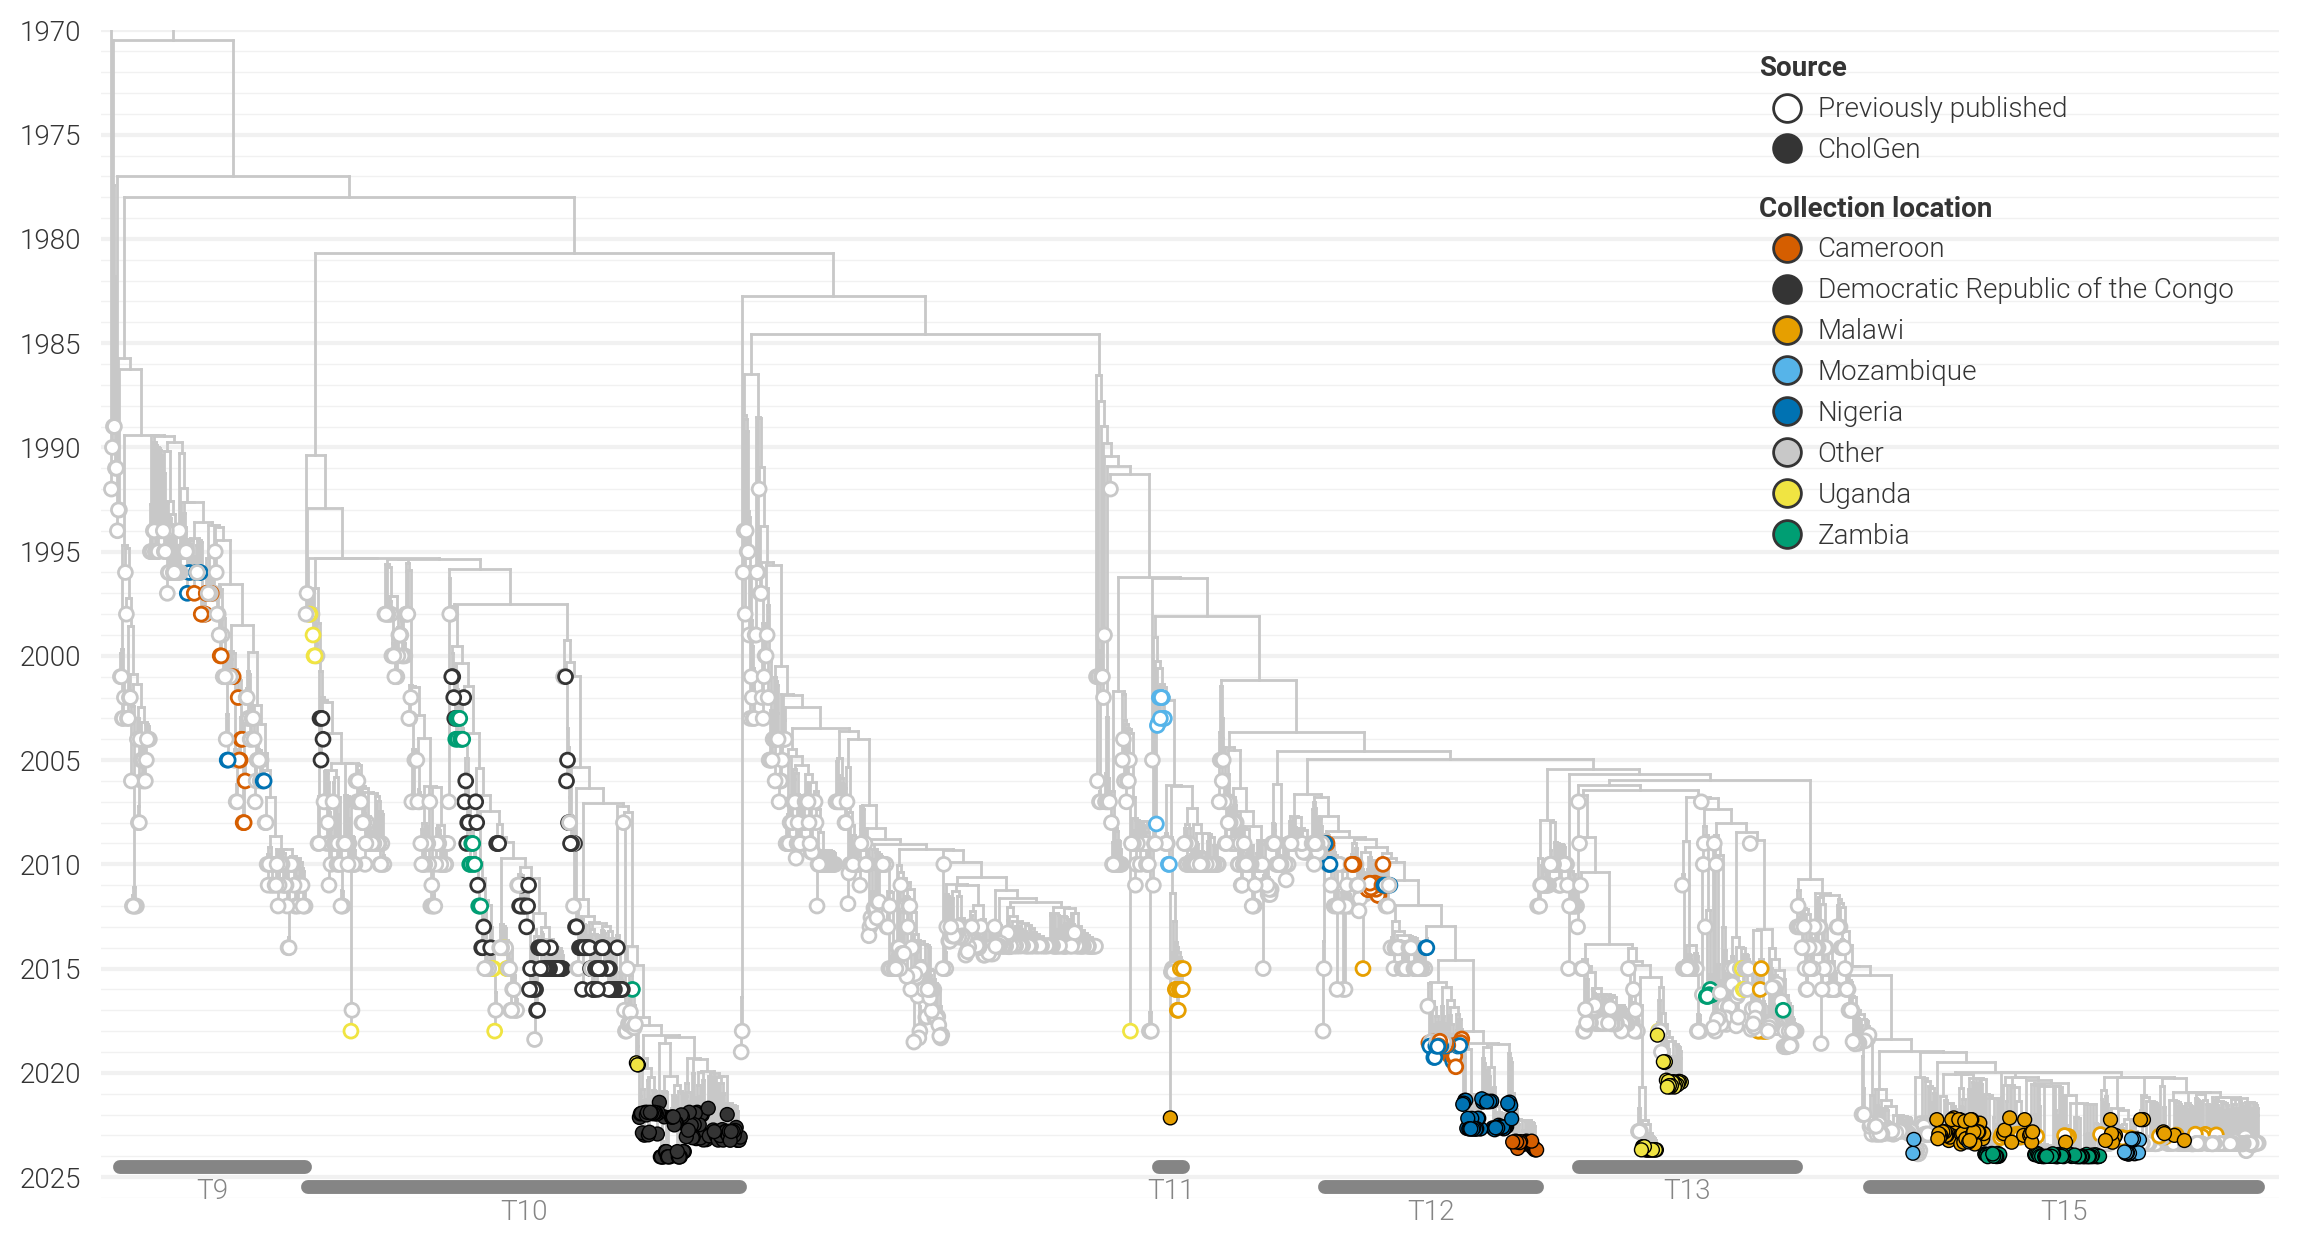

In [4]:
def color_func( label ):
    country = md.loc[label,"country"]
    return color_map.get( country, color_map["Other"] )

def is_workshop( node, inverse=False ):
    if node.is_leaf():
        if inverse:
            return not md.loc[node.name, "workshop"]
        return md.loc[node.name, "workshop"]
    return False

fig, ax = plt.subplots( dpi=200, figsize=(12,6.5) )
x_attr = lambda k: k.absoluteTime
node_func = lambda k: color_func( k.name )
c_func = lambda k: color_map["Other"]
plotTree( tree, ax, x_attr=x_attr, colour=color_map["Other"], linewidth=1, horizontal=True )
plotPoints( tree, ax, x_attr=x_attr, target=lambda x: is_workshop(x, inverse=True), size=25, colour="w", outline_colour=node_func, outline_size=40, zorder=100, horizontal=True, style="nate", linewidth=1 ) # Option 4
plotPoints( tree, ax, x_attr=x_attr, target=is_workshop, size=25, colour=node_func, zorder=150, horizontal=True, style="nate", linewidth=0.5 ) # Option 4
#plotPoints( tree, ax, x_attr=x_attr, target=lambda k : k.is_node() & (k.traits.get( "posterior", 0) > 0.5), color=COLOR, size=2, horizontal=True )

ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params( axis="y", left=False, right=False, which="both", labelbottom=True, labelsize=10 )
ax.set_xlim(-20,tree.ySpan+10)

ax.set_yticks( range( 1970, 2030, 5 ), minor=False )
ax.set_yticks( range( 1970, 2030 ), minor=True )
ax.set_ylim( 1970, 2026 )

ax.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
ax.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )

[ax.spines[loc].set_visible(False) for loc in ax.spines]

legend = [
    Line2D([0], [0], linestyle='none', marker='o', color="white", markeredgecolor=COLOR, markeredgewidth=1, label="Previously published", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color=COLOR, markeredgewidth=1, label="CholGen", markersize=10 ),
]
legend = ax.legend( 
    title="Source", 
    handles=legend, 
    loc="upper left", 
    handletextpad=0.1, 
    frameon=False, 
    fontsize=10, 
    alignment="left", 
    title_fontproperties={"size" : 10, "weight" : "bold" },
    bbox_to_anchor = (0.75,0,1,1)
)

legend2 = [
    Line2D([0], [0], linestyle='none', marker='o', color=color_map[country], markeredgecolor=COLOR, markeredgewidth=1, label=country, markersize=10 ) for country in sorted( color_map.keys() ) 
]

legend2 = ax.legend( title="Collection location", handles=legend2, loc="upper left", handletextpad=0.1, frameon=False, fontsize=10, alignment="left", title_fontproperties={ "size" : 10, "weight" : "bold" }, bbox_to_anchor = (0.75,0,1,0.88) )
fig.add_artist( legend )

count = 0
for lin in ["T9", "T10", "T11", "T12", "T13", "T15"]:
    representatives = md.loc[md["te"]==lin].index.to_list()
    span = [tip.y for tip in tree.getExternal() if tip.name in representatives]
    min_span = min( span )
    max_span = max( span )
##    span = sorted( [tip.y for tip in tree.getExternal( lambda x: x.name in lineage_dict[lin] )] )
    yloc = 2024.5 + 1 * (count % 2)
    ax.hlines( yloc, min_span, max_span, colors=COLOR, alpha=0.6, linewidth=5, capstyle="round", label=lin )
    ax.text( (min_span + max_span) / 2, yloc+1.2, lin, ha="center", va="center", fontsize=10, alpha=0.6 )
    count += 1

ax.invert_yaxis()
ax.invert_xaxis()

plt.tight_layout()
fig.savefig( "plots/figureX-mcc-tree.pdf" )
plt.show()

We then iterate through each of the lineages and plot the subtree corresponding to the lineage. Plotting is basically identical to the whole figure, just at a smaller scale.

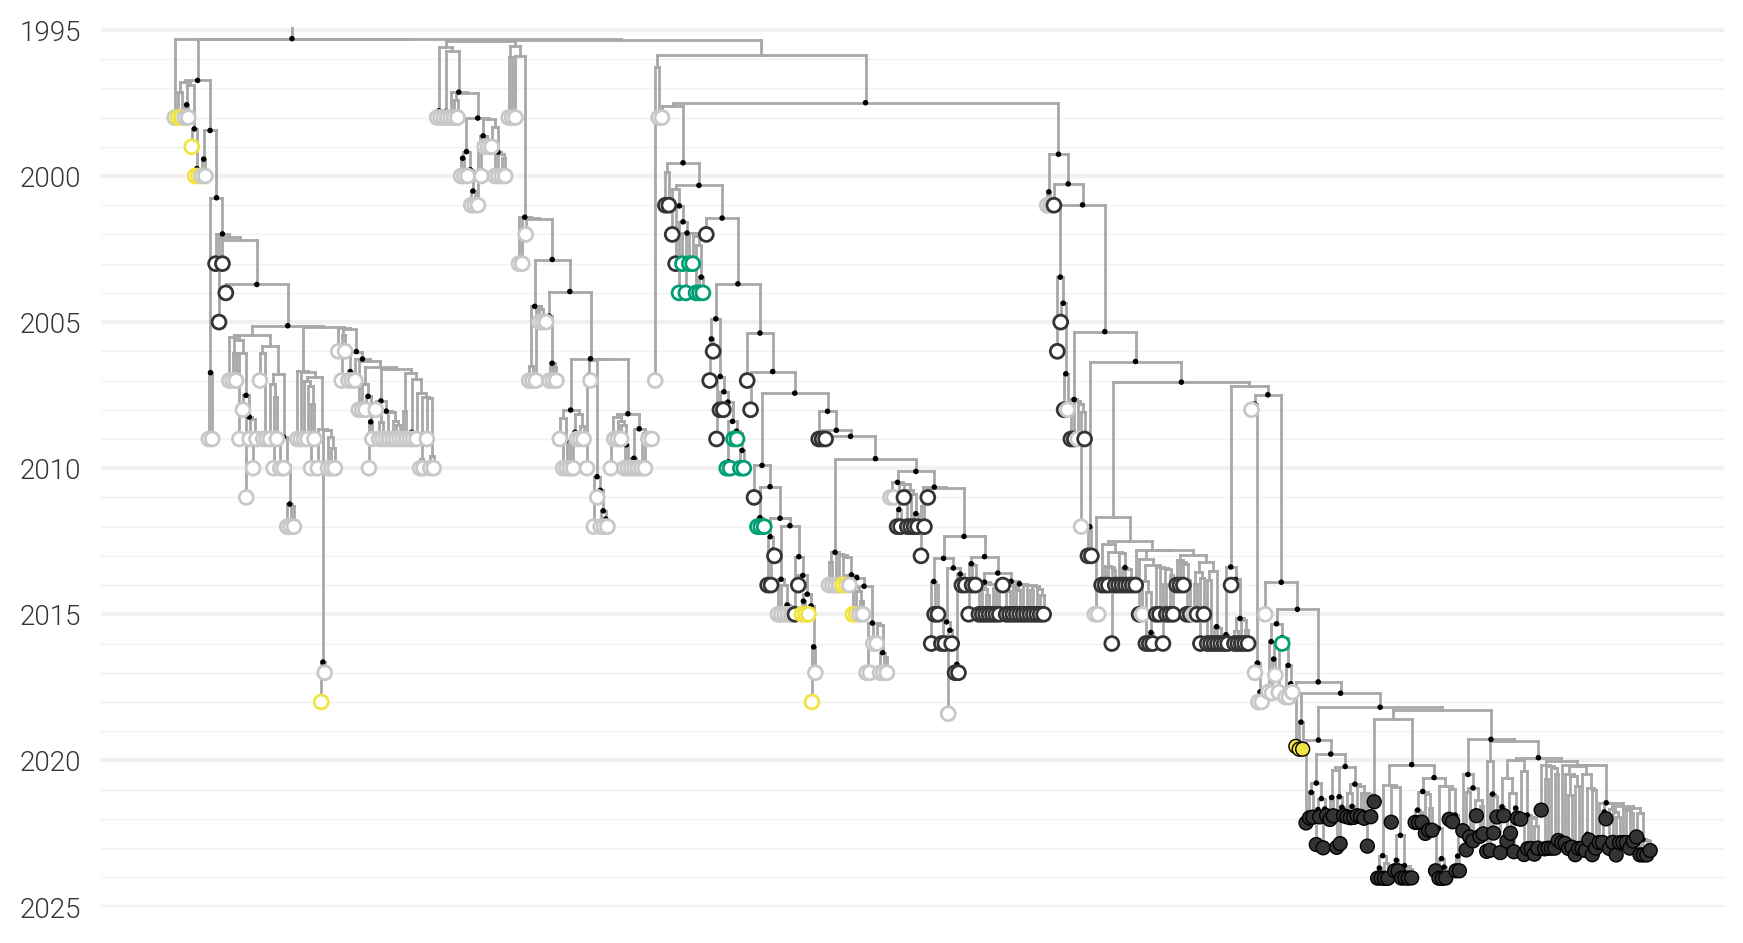

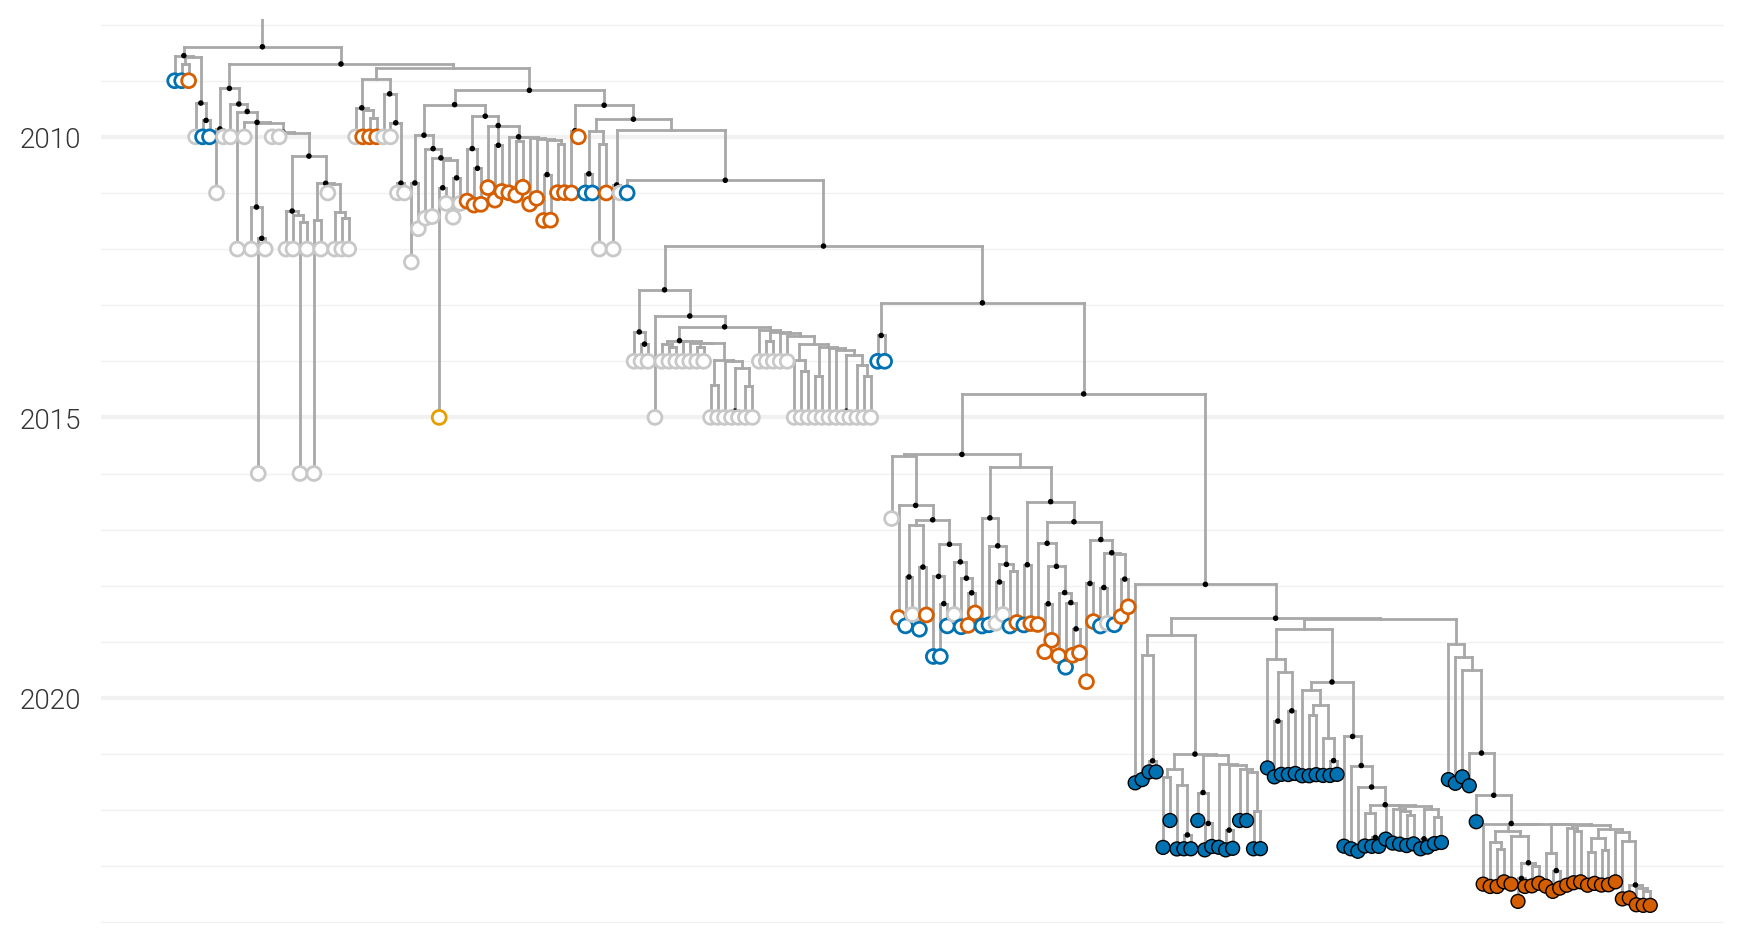

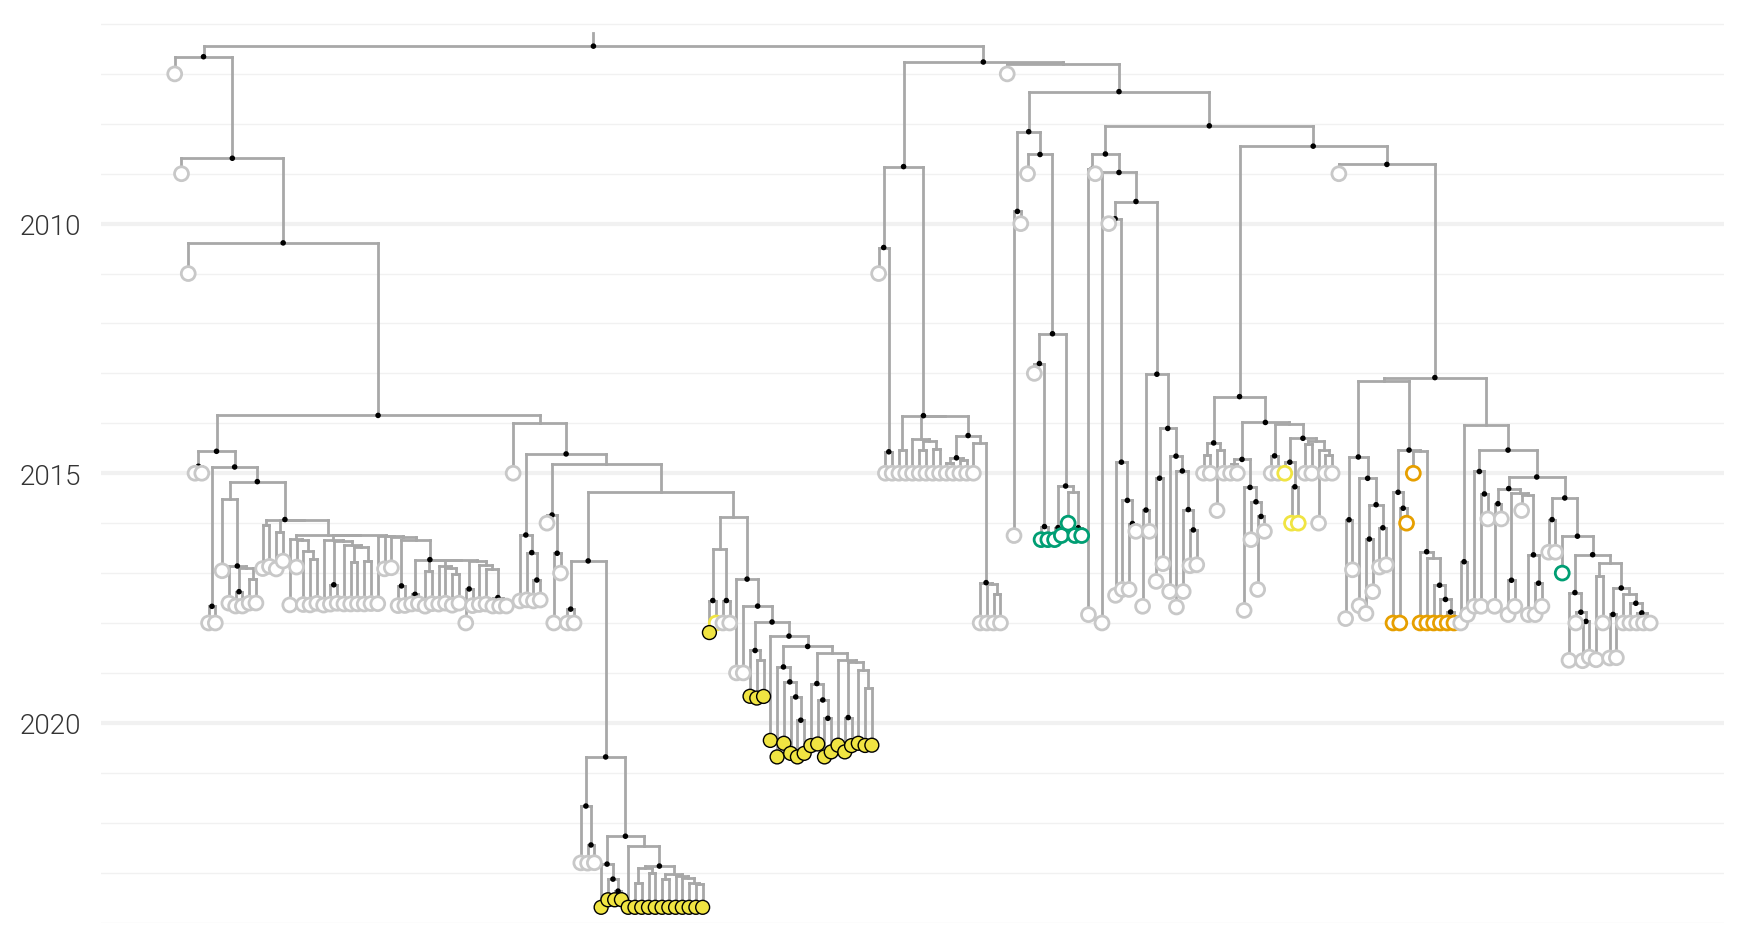

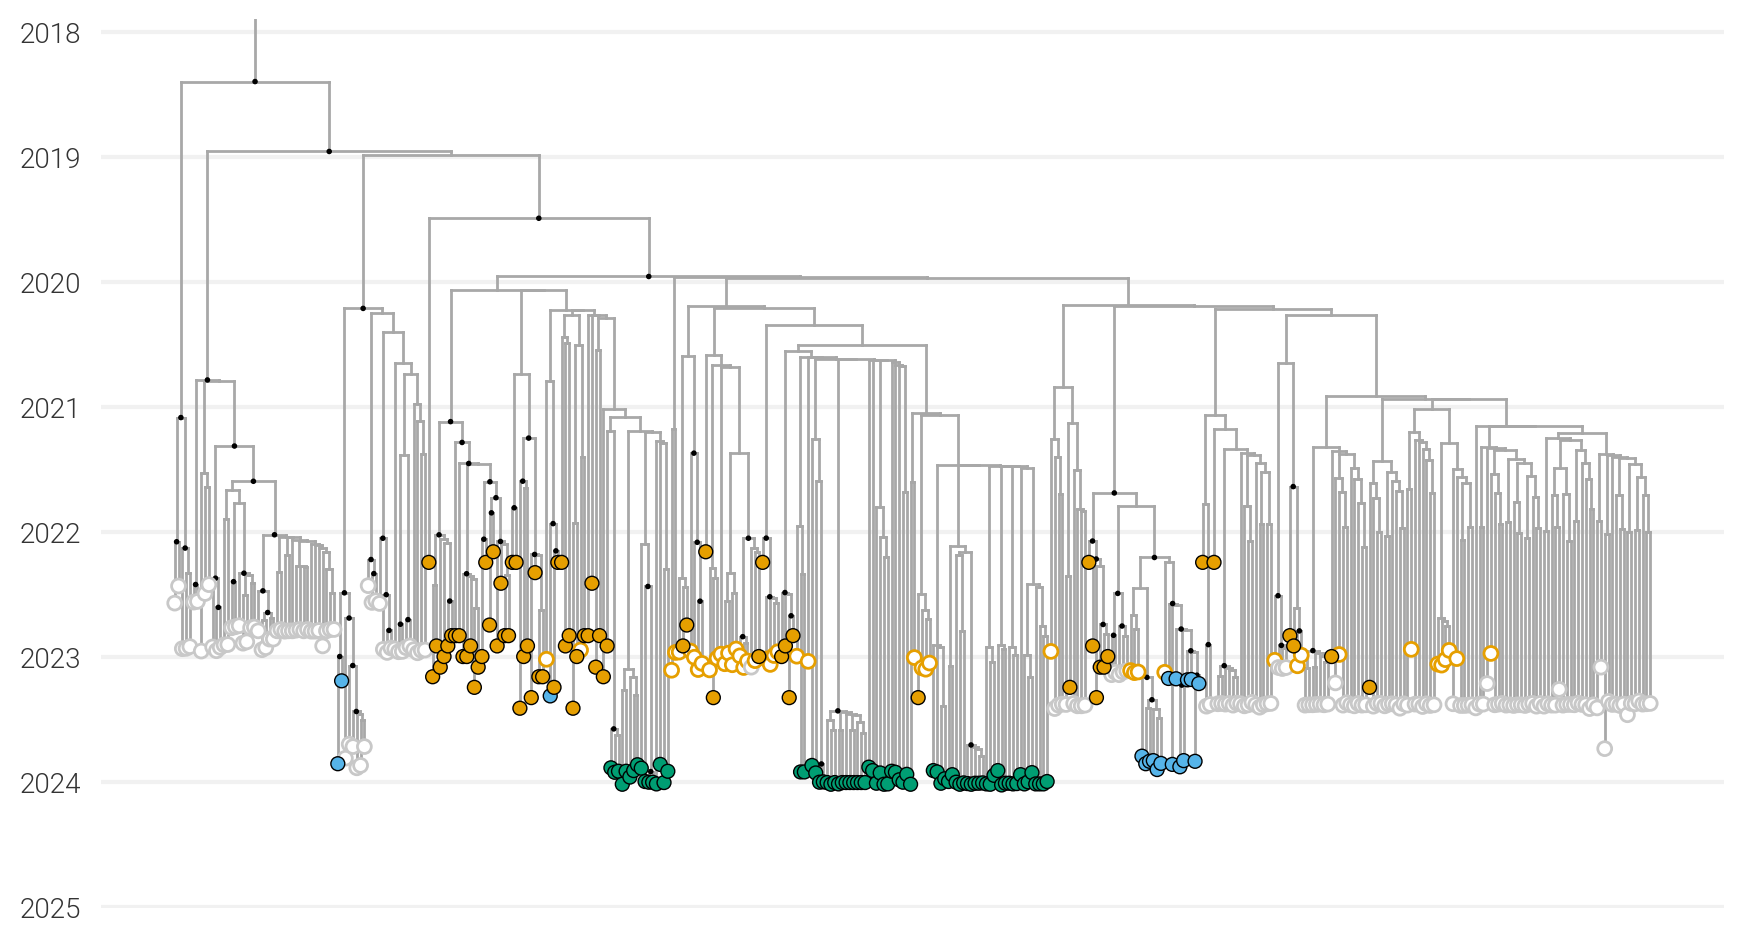

In [8]:
for lin in ["T10", "T12", "T13", "T15"]:
    mrca = tree.commonAncestor([k for k in tree.Objects if k.is_leaf() and k.name in md.loc[md["te"]==lin].index.to_list()])
    if lin == "T12":
        mrca = tree.commonAncestor( [k for k in tree.Objects if k.is_leaf() and k.name in ["Africa|TGO|ERR572839|T12|2010-01-01", "Africa|NGA|ERR1878579|T12|2009-01-01"]] )
    
    mrca = tree.subtree( mrca )
    date_range = [k.absoluteTime for k in mrca.Objects]
    min_year = np.floor( min( date_range ) )
    max_year = np.ceil( max( date_range ) )
    
    fig, ax = plt.subplots( dpi=200, figsize=(9,5) )
    plotTree( mrca, ax, x_attr=x_attr, colour="#A8A8A8", linewidth=1, horizontal=True )
    plotPoints( mrca, ax, x_attr=x_attr, target=lambda x: is_workshop(x, inverse=True), size=25, colour="w", outline_colour=node_func, outline_size=40, zorder=100, horizontal=True, style="nate", linewidth=1 ) # Option 4
    plotPoints( mrca, ax, x_attr=x_attr, target=is_workshop, size=25, colour=node_func, zorder=150, horizontal=True, style="nate", linewidth=0.5 )
    plotPoints( mrca, ax, x_attr=x_attr, target=lambda k : k.is_node() & (k.traits.get( "posterior", 0) > 0.5), color=COLOR, size=2, horizontal=True )
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    ax.set_yticks( range( int( min_year ), int( max_year ) + 1 ), minor=(lin!="T15") )
    
    if lin != "T15":
        ax.set_yticks( range( 1995, int( max_year )+5, 5 ), minor=False )
    
    ax.tick_params( axis="y", left=False, right=False, which="both", labelbottom=True, labelsize=10 )
    ax.set_ylim(min_year-0.1,max_year + 0.01)
    
    ax.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
    ax.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    plt.tight_layout()
    fig.savefig( f"plots/figureX-mcc-tree-{lin}.pdf" )

## T15
The T15 plot requires a bit depth. We'd like to plot the distributions of the TMRCA of the two putative introductions. Here, we extract the members of the two clades, and the distribution of the TMRCA. The members file was generated manually after viewing the tree, while the TMRCA distribution was generated by the `extract_tmrca_t15.ipynb` notebook. The members of the two clades will be used to identify the MRCA of each introduction.

In [9]:
members = dict()
with open( "T15_introductions/lineage_members.txt", "r" ) as members_file:
	for line in members_file:
		if line.strip() == "":
			continue
		elif line.startswith( ">" ):
			group = line.strip().replace( ">", "" )
			members[group] = []
		else:
			members[group].append( line.strip() )

for i in members:
	print( f"{i} - {len( members[i] )} members")

tmrca = pd.read_csv( "T15_introductions/tmrca_t15.csv" )
tmrca.head()

Small - 8 members
Large - 322 members


,tree_id,group,date
0,300,Small,2022.490936
1,300,Large,2019.556459
2,301,Small,2022.937029
3,301,Large,2019.913291
4,302,Small,2022.533689


Finally, we plot the subtree corresponding to the T15 lineage, overlaying the TMRCA distributions ontop of the MRCA of each putative introduction.

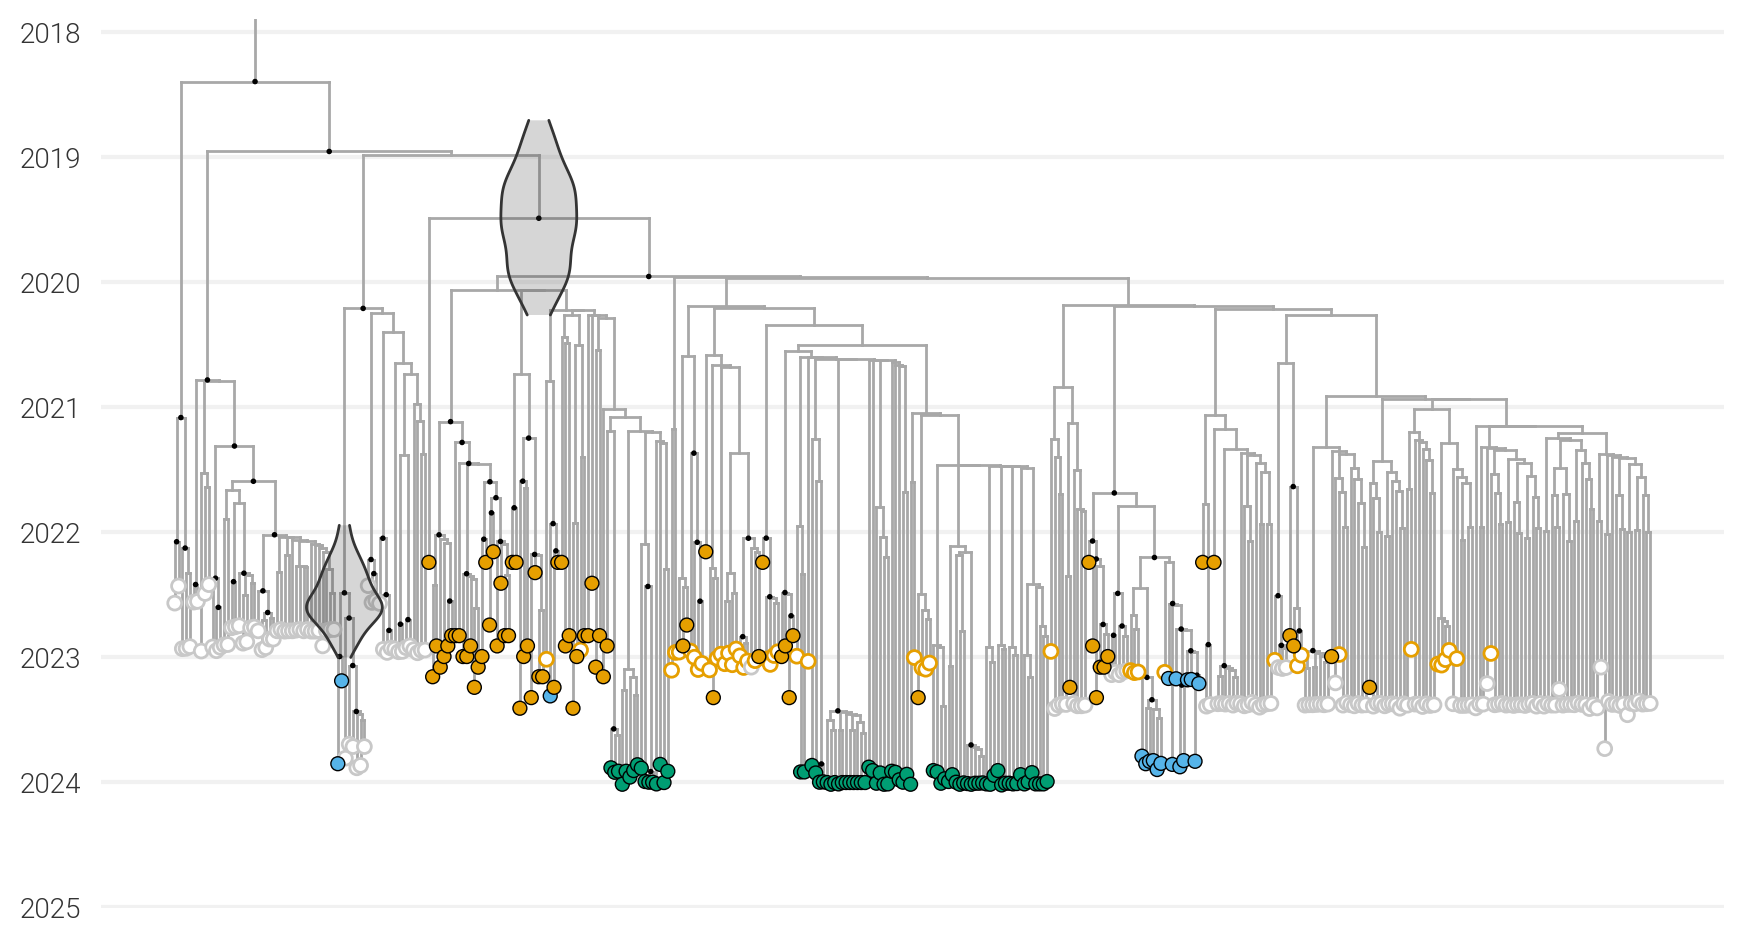

In [11]:
def plot_distribution( ax, data, xloc, width, edgecolor=COLOR, color=COLOR, alpha=0.2 ):
    hpdHi, hpdLo = hpd( data, 0.95 )
    y_grid = np.linspace( hpdLo, hpdHi, 101 )
    
    kde = gaussian_kde( data )
    x_grid = kde.evaluate( y_grid )
    x_grid = x_grid / x_grid.max() * width
    
    ax.plot( [xloc+x for x in x_grid], y_grid, color=edgecolor, lw=1, zorder=101, solid_capstyle="round" )
    ax.plot( [xloc-x for x in x_grid], y_grid, color=edgecolor, lw=1, zorder=101, solid_capstyle="round" )
    
    ax.fill_betweenx( y_grid, [xloc+x for x in x_grid], [xloc-x for x in x_grid], color=color, edgecolor='none', alpha=alpha, zorder=100 )

lin = "T15"
 
mrca = tree.commonAncestor([k for k in tree.Objects if k.is_leaf() and k.name in md.loc[md["te"]==lin].index.to_list()])
mrca = tree.subtree( mrca )
date_range = [k.absoluteTime for k in mrca.Objects]
min_year = np.floor( min( date_range ) )
max_year = np.ceil( max( date_range ) )

fig, ax = plt.subplots( dpi=200, figsize=(9,5) )
plotTree( mrca, ax, x_attr=x_attr, colour="#A8A8A8", linewidth=1, horizontal=True )
plotPoints( mrca, ax, x_attr=x_attr, target=lambda x: is_workshop(x, inverse=True), size=25, colour="w", outline_colour=node_func, outline_size=40, zorder=100, horizontal=True, style="nate", linewidth=1 ) # Option 4
plotPoints( mrca, ax, x_attr=x_attr, target=is_workshop, size=25, colour=node_func, zorder=150, horizontal=True, style="nate", linewidth=0.5 )
plotPoints( mrca, ax, x_attr=x_attr, target=lambda k : k.is_node() & (k.traits.get( "posterior", 0) > 0.5), color=COLOR, size=2, horizontal=True )

small_members = [i for i in mrca.Objects if i.is_leaf() and i.name in members["Small"]]
small_mrca = tree.commonAncestor( small_members )
small_tmrca = tmrca.loc[tmrca["group"]=="Small","date"]
plot_distribution( ax, small_tmrca, small_mrca.y, width=10 )

large_members = [i for i in mrca.Objects if i.is_leaf() and i.name in members["Large"]]
large_mrca = tree.commonAncestor( large_members )
large_tmrca = tmrca.loc[tmrca["group"]=="Large","date"]
plot_distribution( ax, large_tmrca, large_mrca.y, width=10 )

ax.set_xticks([])
ax.set_xticklabels([])

ax.set_yticks( range( int( min_year ), int( max_year ) + 1 ), minor=(lin!="T15") )

if lin != "T15":
    ax.set_yticks( range( 1995, int( max_year )+5, 5 ), minor=False )

ax.tick_params( axis="y", left=False, right=False, which="both", labelbottom=True, labelsize=10 )
ax.set_ylim(min_year-0.1,max_year + 0.01)

ax.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
ax.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )
[ax.spines[loc].set_visible(False) for loc in ax.spines]

ax.invert_xaxis()
ax.invert_yaxis()

plt.tight_layout()
fig.savefig( f"plots/figureX-mcc-tree-T15-dist.pdf" )